# LANL dataset stats

This notebook explores the data from the LANL database

In this notebook, we explore:
- Basic dataset stats


### Prepare the dataset

Run the preparation for the dataset with the `prepare_data` and `setup` methods.

In [ ]:
from datasets.LANL_local import LANLL
from ordered_set import OrderedSet

dataset = LANLL("/data/datasets/LANL", lanl_URL="https://csr.lanl.gov/data-fence/1751407561/mt99_A6PRlVu9-k6lZ0IQ-DbX5E=/cyber1/", to_time=21600)

dataset.prepare_data()
dataset.setup(stage="fit")

/data/Try1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Graph unique (unseen) values
This shows per time bin how many new/unseen values have been observed for every time bin.
- x axis -> each time bin
- y axis -> percentage of unique values

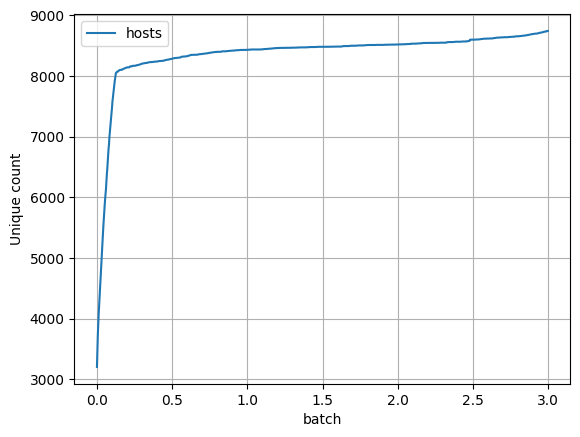

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

def LANL_unique_v1(dataset, show: bool = False):
    # Get dataset columns
    columns = list(next(iter(dataset.generate_bins())).columns)

    # Generate keymaps
    exclude_columns = [
        "time",
        "source computer",
        "destination computer",
        "source user@domain",
        "destination user@domain"
    ]
    keyword_map = {col: OrderedSet([]) for col in columns if col not in exclude_columns}
    hostmap = OrderedSet([])
    usermap = OrderedSet([])

    # Keep track of the added values per column
    added_items_per_bin = {col: [] for col in columns if col not in exclude_columns}
    added_items_per_bin["hosts"] = []
    added_items_per_bin["services"] = []

    def count_updates(ordered_set: OrderedSet, update):
        set_size = len(ordered_set)
        ordered_set.update(update)
        new_size = len(ordered_set)
        return new_size

    def show_plot(added_items_per_bin):
        if show == False:
            return
        
        df = pd.DataFrame(added_items_per_bin)

        clear_output(wait=True)
        df.index = df.index/dataset.batch_size
        ax = df[["hosts"]].plot(xlabel="batch", ylabel="Unique count")
        plt.grid(True)
        plt.show()

    for batch_id, (batch, stage) in enumerate(dataset.generate_batches()):
        # Go trough every bin
        for bin in batch:
            # Update keyword map
            for col in keyword_map.keys():
                diff = count_updates(keyword_map[col], bin[col].dropna().unique())
                added_items_per_bin[col].append(diff)
            
            diff1 = count_updates(hostmap, bin["source computer"].dropna().unique())
            diff2 = count_updates(hostmap, bin["destination computer"].dropna().unique())
            added_items_per_bin["hosts"].append(diff1 + diff2)

            diff1 = count_updates(usermap, bin["source user@domain"].dropna().unique())
            diff2 = count_updates(usermap, bin["destination user@domain"].dropna().unique())
            added_items_per_bin["services"].append(diff1 + diff2)

        show_plot(added_items_per_bin)


    show_plot(added_items_per_bin)
    df = pd.DataFrame(added_items_per_bin)
    df.to_parquet("keywordmap_percent.parquet")

LANL_unique_v1(dataset, show=True)

### Graph unique (unseen) values v2
The same graph is also observed per stage, assuming the data is fed to the algorithm in the following sequence: 'train', 'validation', 'test'.

<Figure size 1000x500 with 0 Axes>

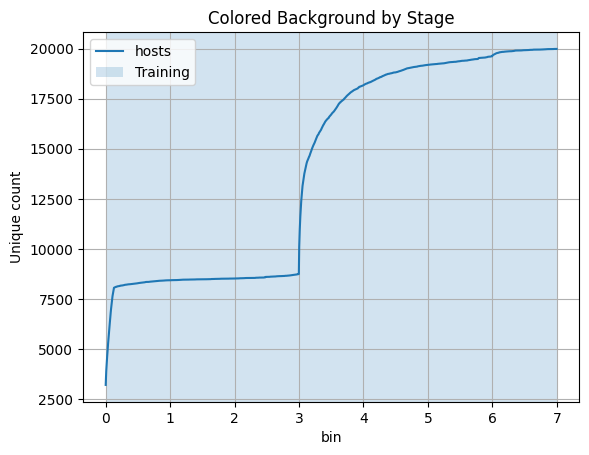

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

def LANL_unique_v2(dataset, show: bool = False):
    # Get dataset columns
    columns = list(next(iter(dataset.generate_bins())).columns)

    # Generate keymaps
    exclude_columns = [
        "time",
        "source computer",
        "destination computer",
        "source user@domain",
        "destination user@domain"
    ]
    keyword_map = {col: OrderedSet([]) for col in columns if col not in exclude_columns}
    hostmap = OrderedSet([])
    usermap = OrderedSet([])

    # Keep track of the added values per column
    added_items_per_bin = {col: [] for col in columns if col not in exclude_columns}
    added_items_per_bin["hosts"] = []
    added_items_per_bin["services"] = []
    added_items_per_bin["stage"] = []

    def count_updates(ordered_set: OrderedSet, update):
        set_size = len(ordered_set)
        ordered_set.update(update)
        new_size = len(ordered_set)
        return new_size

    def show_plot(added_items_per_bin):
        if show == False:
            return
        
        df = pd.DataFrame(added_items_per_bin)

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))

        # Plot the data
        df.index = df.index/dataset.batch_size
        ax = df[["hosts"]].plot(xlabel="bin", ylabel="Unique count")

        # Get unique stages and their x ranges
        for stage, group in df.groupby("stage"):
            x_start = group.index.min()
            x_end = group.index.max()

            stage_label = "Training"
            if stage == 1:
                stage_label = "Validation"
            if stage == 2:
                stage_label = "Testing"

            plt.axvspan(x_start, x_end, alpha=0.2, label=stage_label)

        plt.title("Colored Background by Stage")
        plt.legend()
        plt.grid(True)
        plt.show()

    for batch_id, (batch, stage) in enumerate(dataset.generate_batches(0)):
        # Go trough every bin
        for bin in batch:
            # Update keyword map
            for col in keyword_map.keys():
                diff = count_updates(keyword_map[col], bin[col].dropna().unique())
                added_items_per_bin[col].append(diff)
            
            diff1 = count_updates(hostmap, bin["source computer"].dropna().unique())
            diff2 = count_updates(hostmap, bin["destination computer"].dropna().unique())
            added_items_per_bin["hosts"].append(diff1 + diff2)

            diff1 = count_updates(usermap, bin["source user@domain"].dropna().unique())
            diff2 = count_updates(usermap, bin["destination user@domain"].dropna().unique())
            added_items_per_bin["services"].append(diff1 + diff2)

            added_items_per_bin["stage"].append(stage)

        show_plot(added_items_per_bin)

    for batch_id, (batch, stage) in enumerate(dataset.generate_batches(1)):
        # Go trough every bin
        for bin in batch:
            # Update keyword map
            for col in keyword_map.keys():
                diff = count_updates(keyword_map[col], bin[col].dropna().unique())
                added_items_per_bin[col].append(diff)
            
            diff1 = count_updates(hostmap, bin["source computer"].dropna().unique())
            diff2 = count_updates(hostmap, bin["destination computer"].dropna().unique())
            added_items_per_bin["hosts"].append(diff1 + diff2)

            diff1 = count_updates(usermap, bin["source user@domain"].dropna().unique())
            diff2 = count_updates(usermap, bin["destination user@domain"].dropna().unique())
            added_items_per_bin["services"].append(diff1 + diff2)

            added_items_per_bin["stage"].append(stage)

        show_plot(added_items_per_bin)

    for batch_id, (batch, stage) in enumerate(dataset.generate_batches(2)):
        # Go trough every bin
        for bin in batch:
            # Update keyword map
            for col in keyword_map.keys():
                diff = count_updates(keyword_map[col], bin[col].dropna().unique())
                added_items_per_bin[col].append(diff)
            
            diff1 = count_updates(hostmap, bin["source computer"].dropna().unique())
            diff2 = count_updates(hostmap, bin["destination computer"].dropna().unique())
            added_items_per_bin["hosts"].append(diff1 + diff2)

            diff1 = count_updates(usermap, bin["source user@domain"].dropna().unique())
            diff2 = count_updates(usermap, bin["destination user@domain"].dropna().unique())
            added_items_per_bin["services"].append(diff1 + diff2)

            added_items_per_bin["stage"].append(stage)

        show_plot(added_items_per_bin)

    show_plot(added_items_per_bin)
    df = pd.DataFrame(added_items_per_bin)
    df.to_parquet("keywordmap_percentv2.parquet")

LANL_unique_v2(dataset, show=True)